# Anirban Bairagi
# 17PH20005
# COVID19Action-Radiology-CXR

In [1]:
import numpy as np
import pandas as pd
import shutil 
import os 
import math
import torchvision.transforms.functional as TF
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn. preprocessing import LabelEncoder
from sklearn. preprocessing import OneHotEncoder
from numpy import argmax
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline

# Data Processing

In [10]:
current_dir=os.getcwd()

In [ ]:



mode=['Test','Train']

for i in mode:
    

    df=pd.read_csv(str(current_dir)+"/"+str(i)+"_Combined.csv")
    Covid_19=df[(df['COVID-19']==1)]
    Other=df[(df['COVID-19']==0)]
    vars()["Covid_filename_"+str(i)]=Covid_19['Image Name'].to_numpy()
    vars()["Others_filename_"+str(i)]=Other['Image Name'].to_numpy()
    
    
    

print(current_dir)



In [ ]:
l=['Train','Test']
m=['Covid','Others']

for name in l:
        
    for i in m:
        dirname=current_dir+'/COVID/preprocessed/'+name+'/'+str(i)
        if os.path.isdir(dirname):
            shutil.rmtree(dirname)
        os.makedirs(dirname) 
                
        count=0
        
        for j in range(7):
            if j==2 or j==3 :
                continue
            
            path=str(current_dir)+'/images/Source'+str(j+1)
            os.chdir(path)
            
            for k in range(len(vars()[str(i)+"_filename_"+str(name)])):
                
                print(vars()[i+"_filename_"+name].item(k))
            
                if os.path.exists(path+'/'+str(vars()[str(i)+"_filename_"+str(name)].item(k))):
                    
                    count+=1
                    
                    shutil.copy(str(vars()[str(i)+"_filename_"+str(name)].item(k)), dirname)
                    
                else:
                    
                    
                    
                    continue
            
        
            
       
    
    
    

# Training

In [3]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
import torchvision.transforms.functional as TF

PyTorch Version:  1.4.0
Torchvision Version:  0.5.0


In [4]:
cuda = torch.cuda.is_available()
if cuda:
    print('cuda is available')

cuda is available


In [19]:
#models are=[resnet, alexnet, vgg, squeezenet, densenet, inception]

# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = current_dir+"/COVID/preprocessed"    #write your code---------------

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "densenet"   #write your code---------------

# Number of classes in the dataset
num_classes = 2      #write your code---------------

# Batch size for training (change depending on how much memory you have)
batch_size = 16       #write your code---------------

# Number of epochs to train for
num_epochs = 10      #write your code---------------

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True




In [6]:
torch.cuda.empty_cache()
torch.cuda.reset_max_memory_allocated(device=None)
torch.cuda.reset_max_memory_cached(device=None)

In [7]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False    #when we are feaure extracting
def f1_score_new(train_label,train_pred,val_label,val_pred,train_acc,val_acc,epoch):
    
    
    mode='binary'
 
   
  
    
    f1_train=f1_score(train_label,train_pred,average=mode)
    prec_train=precision_score(train_label,train_pred,average=mode)
    rec_train=recall_score(train_label,train_pred,average=mode)
    ############
    #print(train_label)
    #print(train_pred)
    #print(np.shape(train_label))
    #print(np.shape(train_pred))
    ##########3

    
    ##########3

    f1_val=f1_score(val_label,val_pred,average=mode)
    prec_val=precision_score(val_label,val_pred,average=mode)
    rec_val=recall_score(val_label,val_pred,average=mode)
    ############
    #print(val_label)
    #print(val_pred)
    #print(np.shape(val_label))
    #print(np.shape(val_pred))
    
    
    print("  {}        {:.3f}       {:.3f}      {:.3f}      {:.3f}       {:.3f}       {:.3f}         {:.3f}        {:.3f}".format(epoch+1,train_acc,val_acc,f1_train,f1_val,prec_train,prec_val,rec_train,rec_val))
    
    return f1_train, prec_train, rec_train, f1_val, prec_val, rec_val

In [8]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, is_inception=False):
    since = time.time()
    print("Epoch    Train_acc   Val_acc    train_F1:   val_F1:    train_Preci    train_rec   Val_preci   Val_rec")
        
    tr_acc=[]
    vl_acc=[]
    tr_f1=[]
    vl_f1=[]
    tr_prec=[]
    vl_prec=[]
    tr_rec=[]
    vl_rec=[]
    

    
    best_acc = 0.0

    for epoch in range(num_epochs):
        
        
       # print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 100)
        
        
        
        # Each epoch has a training and validation phase
        for phase in ['Train', 'Test']:
            if phase == 'Train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
 #               print("type of input: " +str(type(inputs)))
                inputs = inputs.to(device)
                labels = labels.to(device)
  #              print("type of input after to the device: " +str(type(inputs)))

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'Train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)
                    #my code
                    label=labels.data.cpu().numpy()
                    pred=preds.cpu().numpy()
                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            #print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            
            if phase =='Train':
                train_acc=epoch_acc
                train_label=label        
                train_pred=pred
           #     train_acc_history.append(epoch_acc)
                
               # print("The size of train_pred "+str(train_pred.shape))
            if phase == 'Test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                
            if phase == 'Test':
                val_acc=epoch_acc
                val_label=label
                val_pred=pred
                #val_acc_history.append(epoch_acc)
                f1_train, prec_train, rec_train, f1_val, prec_val, rec_val=f1_score_new(train_label,train_pred,val_label,val_pred,train_acc,val_acc,epoch)
                tr_acc.append(train_acc)
                vl_acc.append(val_acc)
                tr_f1.append(f1_train)
                vl_f1.append(f1_val)
                tr_prec.append(prec_train)
                vl_prec.append(prec_val)
                tr_rec.append(rec_train)
                vl_rec.append(rec_val)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))


    return model, tr_acc, vl_acc,  tr_f1, tr_prec, tr_rec, vl_f1, vl_prec, vl_rec









In [9]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [10]:

def one_hot_encoder(array):
    
    
    a=np.array([[0],[1],[2],[3],[4],[5],[6],[7],[8],[9]])
    onehot_encoder = OneHotEncoder(categories='auto',sparse=False, dtype=int, n_values=10)
    onehot_encoded=onehot_encoder.fit(a).transform(array.reshape(len(array), 1))
    return onehot_encoded


In [13]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'Train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['Train', 'Test']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['Train', 'Test']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [14]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=0.001)

Params to learn:
	 classifier.weight
	 classifier.bias


In [15]:
for param in model_ft.classifier.parameters():
    print(param.requires_grad)

True
True


In [16]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
def model_selec(dataloaders_dict, criterion, num_epochs, l_rate):
    print("                                                                   Learning Rate=",l_rate)
    optimizer_ft = optim.Adam(model_ft.classifier.parameters(), lr=l_rate)
    model, train_acc, val_acc,  f1_train, prec_train, rec_train, f1_val, prec_val, rec_val = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))
   

    return model, train_acc, val_acc,  f1_train, prec_train, rec_train, f1_val, prec_val, rec_val

In [20]:
#l=[0.6,0.1]
l=[0.9,0.6,0.1,0.06,0.03,0.01,0.006]
#l=[0.06,0.03,0.01,0.006,]
tr_acc=[]
vl_acc=[]
tr_f1=[]
vl_f1=[]
tr_prec=[]
vl_prec=[]
tr_rec=[]
vl_rec=[]
#for 100 epochs
for i in l:
    model_ft, train_acc, val_acc,  f1_train, prec_train, rec_train, f1_val, prec_val, rec_val = model_selec(dataloaders_dict, criterion, num_epochs,i)
    
    tr_acc.append(train_acc[-1].item())
    vl_acc.append(val_acc[-1].item())
    tr_f1.append(f1_train[-1].item())
    vl_f1.append(f1_val[-1].item())
    tr_prec.append(prec_train[-1].item())
    vl_prec.append(prec_val[-1].item())
    tr_rec.append(rec_train[-1].item())
    vl_rec.append(rec_val[-1].item())
    
    time.sleep(60)

                                                                   Learning Rate= 0.9
Epoch    Train_acc   Val_acc    train_F1:   val_F1:    train_Preci    train_rec   Val_preci   Val_rec
----------------------------------------------------------------------------------------------------
  1        0.617       0.686      0.000      0.000       0.000       0.000         0.000        0.000

----------------------------------------------------------------------------------------------------
  2        0.650       0.286      0.889      0.000       0.800       0.000         1.000        0.000

----------------------------------------------------------------------------------------------------
  3        0.623       0.371      0.286      0.500       0.167       0.333         1.000        1.000

----------------------------------------------------------------------------------------------------
  4        0.683       0.686      0.000      0.000       0.000       0.000         0.000        0.0

  7        0.825       0.771      0.800      0.667       0.667       0.500         1.000        1.000

----------------------------------------------------------------------------------------------------
  8        0.874       0.743      0.000      0.000       0.000       0.000         0.000        0.000

----------------------------------------------------------------------------------------------------
  9        0.852       0.771      1.000      0.000       1.000       0.000         1.000        0.000

----------------------------------------------------------------------------------------------------
  10        0.852       0.771      0.400      0.000       0.500       0.000         0.333        0.000

Training complete in 1m 8s
Best val Acc: 0.800000
                                                                   Learning Rate= 0.03
Epoch    Train_acc   Val_acc    train_F1:   val_F1:    train_Preci    train_rec   Val_preci   Val_rec
---------------------------------------------

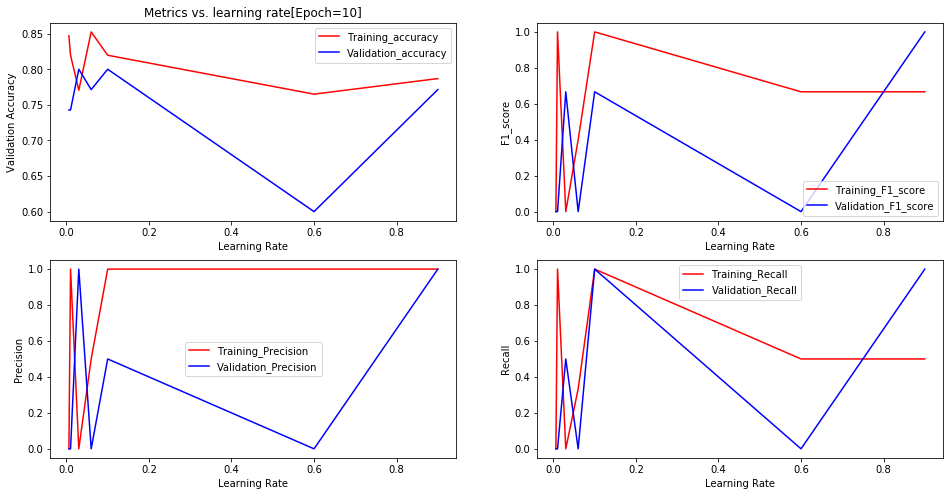

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

fig=plt.figure("Random numbers(0<x<1) and their probabiities ",figsize=(16,8))

plt.subplot(221)

plt.title("Metrics vs. learning rate[Epoch="+str(num_epochs)+"]" , fontdict=None, loc='center', pad=None)

plt.xlabel("Learning Rate")
plt.ylabel("Validation Accuracy")
plt.plot(l,tr_acc,label="Training_accuracy", color="red")
plt.plot(l,vl_acc,label="Validation_accuracy", color="blue")
plt.legend()

plt.subplot(222)

#plt.title("F1_score vs. learning rate[Epoch="+str(10)+"]" , fontdict=None, loc='center', pad=None)
plt.xlabel("Learning Rate")
plt.ylabel("F1_score")
plt.plot(l,tr_f1,label="Training_F1_score", color="red")
plt.plot(l,vl_f1,label="Validation_F1_score", color="blue")
plt.legend()
plt.subplot(223)

#plt.title("Precision vs. learning rate[Epoch="+str(10)+"]" , fontdict=None, loc='center', pad=None)
plt.xlabel("Learning Rate")
plt.ylabel("Precision")
plt.plot(l,tr_prec,label="Training_Precision", color="red")
plt.plot(l,vl_prec,label="Validation_Precision", color="blue")
plt.legend()

plt.subplot(224)

#plt.title("Recall vs. learning rate[Epoch="+str(10)+"]" , fontdict=None, loc='center', pad=None)
plt.xlabel("Learning Rate")
plt.ylabel("Recall")
plt.plot(l,tr_rec,label="Training_Recall", color="red")
plt.plot(l,vl_rec,label="Validation_Recall", color="blue")
plt.legend()


plt.show()
